In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
from scipy.stats import wasserstein_distance

In [3]:
def get_pandas_dict(dirpath):
    # Getting filelist:
    file_list = os.listdir(dirpath)
    pandas_dict = {}

    # Iterating through list:
    for filename in file_list:
        filepath = os.path.join(dirpath, filename)
        if os.path.isdir(filepath):
            continue
        if ".txt" not in filepath:
            continue
        pandas_dict[filename.split(".")[0]] = pd.read_csv(filepath, header=2, sep="\t")

    return pandas_dict

In [4]:
pd_dict = get_pandas_dict("F91S Amantadine Analysis/Input Feature Files")

In [5]:
keys = list(pd_dict.keys())
keys.sort()
keys

['F91SAMT1_0',
 'F91SAMT2_0',
 'F91SAMT3_0',
 'F91SDOX1_0',
 'F91SDOX2_0',
 'F91SDOX3_0',
 'WTAMT1_0',
 'WTAMT2_0',
 'WTAMT3_0',
 'WTDOX1_0',
 'WTDOX2_0',
 'WTDOX3_0']

In [6]:
features = list(pd_dict["WTDOX1_0"])
features.sort()

In [7]:
included_ch = ["01", "02", "06", "11", "Cytoplasm", "Perimembrane"] 
lda_feature_list = [feature for feature in features if any(ch in feature for ch in included_ch)]
excluded_features = [feature for feature in features if not any(ch in feature for ch in included_ch)]

In [8]:
# Getting numpy array of features:
condition_list = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
condition_label_dict = {
    "WTDOX": 0, "WTAMT": 1, "F91SDOX": 2, "F91SAMT": 3
}
label_array = []
data_array = []
collapse_indices = [0]
for condition in condition_list:
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        data = pd_dict[label][lda_feature_list]
        arr = np.asarray(data)
        print(arr.shape)
        
        # Appending data and labels:
        label = condition_label_dict[condition]
        temp_label_arr = np.full(arr.shape[0], label)
        label_array.append(temp_label_arr)
        data_array.append(arr)
        
        collapse_indices.append(arr.shape[0] + collapse_indices[-1])

label_array = np.concatenate(label_array, axis=0)
data_array = np.concatenate(data_array, axis=0)

(3573, 382)
(3290, 382)
(3636, 382)
(3837, 382)
(3479, 382)
(3466, 382)
(3778, 382)
(3329, 382)
(3532, 382)
(3582, 382)
(3545, 382)
(3281, 382)


In [9]:
# Clipping and logging all values:
normed_array = np.log(np.clip(data_array, 1e-5, None))

# Performing z-score normalisation data prior to random forest feature importance scoring:
means = np.mean(normed_array, axis=0, keepdims=True)
std = np.std(normed_array, axis=0, keepdims=True)

# Removing zero-variance features (these will be things like saturation count):
std_mask = np.squeeze(std > 0)

normed_array = (normed_array[:, std_mask] - means[:, std_mask]) / std[:, std_mask]

In [10]:
normed_array.shape

(42328, 380)

In [98]:
# Making single channel feature lists:

normed_feature_list = list(np.array(lda_feature_list)[std_mask])

m2_include = ["11"] 
m2_features = [feature for feature in features if any(ch in feature for ch in m2_include)]
m2_feature_indices = [idx for idx, feature in enumerate(normed_feature_list) if feature in m2_features]
m2_array = normed_array[:, m2_feature_indices]

gfplc3_include = ["02"] 
gfplc3_features = [feature for feature in features if any(ch in feature for ch in gfplc3_include)]
gfplc3_feature_indices = [idx for idx, feature in enumerate(normed_feature_list) if feature in gfplc3_features]
gfplc3_array = normed_array[:, gfplc3_feature_indices]

## 1 Performing LDA analyses with all available features:

In [63]:
# Performing LDA and transforming into most discriminable space:
lda_clf = LinearDiscriminantAnalysis(n_components=2)
lda_embeddings = lda_clf.fit_transform(normed_array, label_array)

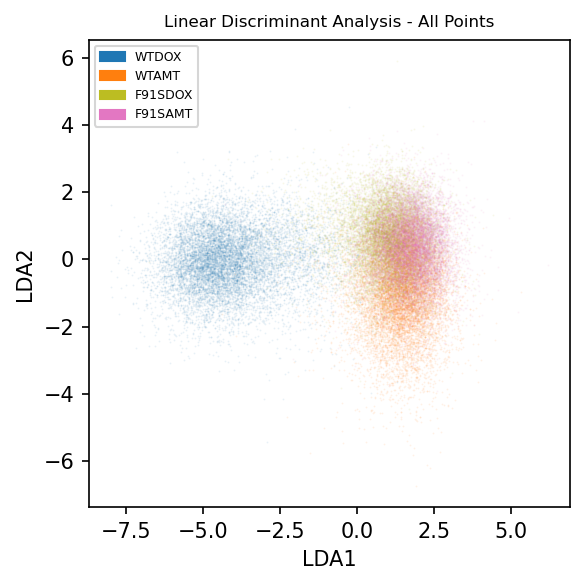

In [64]:
# Plotting first two components of LDA dimension reduction:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
col_labels = np.array(['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink'])

count = 0
for cond_num in range(4):
    cond_arr = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        cond_arr.append(arr)
    cond_arr = np.concatenate(cond_arr, axis=0)
    ax.scatter(
        x=cond_arr[:, 0], y=cond_arr[:, 1], s=3, marker=".", alpha=0.1,
        c=col_labels[cond_num], label=str_labels[cond_num], linewidths=0
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, str_labels, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - All Points", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="F91S Amantadine Analysis/Output Figures/Linear Discriminant Analysis - All Points.png", format="png")

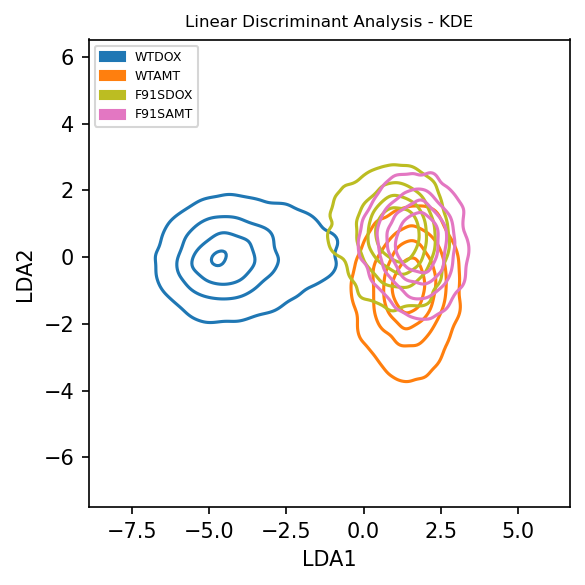

In [65]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 3, :], columns=["LDA1", "LDA2"]),
]

# Formatting data
str_labels = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = 'tab:blue', 'tab:orange', 'tab:olive', 'tab:pink'
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="F91S Amantadine Analysis/Output Figures/Linear Discriminant Analysis - KDE.png", format="png")

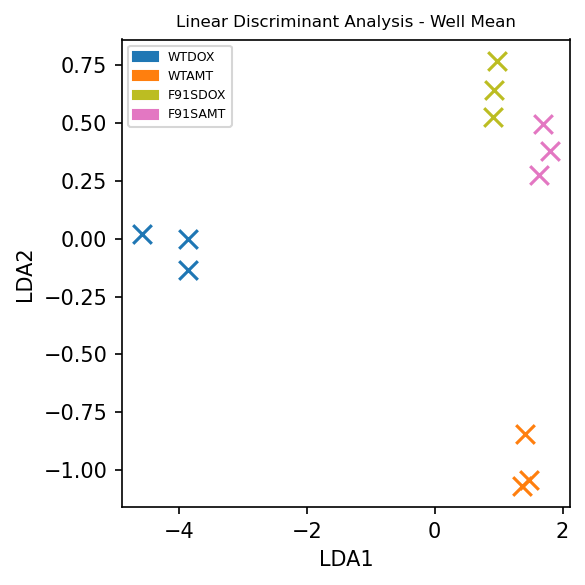

In [66]:
# Generating well averages plot:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
col_labels = np.array(['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink'])

count = 0
for cond_num in range(4):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        well_average = np.mean(arr, axis=0)
        cond_averages.append(well_average)
    cond_averages = np.stack(cond_averages, axis=0)
    ax.scatter(
        x=cond_averages[:, 0], y=cond_averages[:, 1], s=80, marker="x",
        c=col_labels[cond_num], label=str_labels[cond_num]
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, str_labels, prop={'size': 6}, loc=0)

# Titling figure:
plt.title(label="Linear Discriminant Analysis - Well Mean", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="F91S Amantadine Analysis/Output Figures/Linear Discriminant Analysis - Well Mean.png", format="png")

In [133]:
def get_embedding_arrays(embeddings):
    count = 0
    condition_dict = {}
    for condition in range(4):
        condition_arrays = []
        for repeat in range(3):
            # Selecting data:
            start_idx = collapse_indices[count]
            end_idx = collapse_indices[count+1]
            count += 1
            cr_embeddings = embeddings[start_idx:end_idx, :]
            condition_arrays.append(cr_embeddings)
        condition_dict[condition] = condition_arrays
    return condition_dict

def calculate_distance(embeddings_a, embeddings_b):
    distance_dim1 = wasserstein_distance(embeddings_a[:, 0], embeddings_b[:, 0])
    distance_dim2 = wasserstein_distance(embeddings_a[:, 1], embeddings_b[:, 1])
    return distance_dim1 + distance_dim2
    

def calculate_diff_distance(condition_dict, cond_1, cond_2):
    # Calculating distances within conditions:
    arrlist_condA = condition_dict[cond_1]
    arrlist_condB = condition_dict[cond_2]
    
    A_distances = []
    B_distances = []
    for i in range(3):
        # Calculating for cond A:
        dist_A = calculate_distance(arrlist_condA[i], arrlist_condA[(i+1)%3])
        A_distances.append(dist_A)        

        # Calculating for cond B:
        dist_B = calculate_distance(arrlist_condB[i], arrlist_condB[(i+1)%3])
        B_distances.append(dist_B)
        

    # Calculating distance between conditions:
    full_arr_A = np.concatenate(arrlist_condA, axis=0)
    full_arr_B = np.concatenate(arrlist_condB, axis=0)
    full_distance = calculate_distance(full_arr_A, full_arr_B)
    
    print(A_distances)
    print(np.mean(A_distances))
    print(B_distances)
    print(np.mean(B_distances))
    print(full_distance)

In [134]:
# Calculating distance between WTDOX and WTAMT:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 0, 1)

[0.8676144786176523, 0.1711867797508072, 0.7414023060719281]
0.5934011881467959
[0.2839711241631558, 0.1536308939717566, 0.2659754426943318]
0.23452582027641475
6.4627034920323085


In [135]:
# Calculating distance between WTAMT and F91SAMT:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 1, 3)

[0.2839711241631558, 0.1536308939717566, 0.2659754426943318]
0.23452582027641475
[0.22784626616403014, 0.2647832701009464, 0.2718578194552457]
0.2548291185734074
1.6601846081643779


In [93]:
# Calculating distance between F91SDOX and F91SAMT:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 2, 3)

[0.31421227480156, 0.1409878058430638, 0.19070855326126743]
[0.22784626616403014, 0.2647832701009464, 0.2718578194552457]
1.0314587689372283


## 2 Examining M2 and LC3 Relocalisation:

In [123]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Modulation_Cytoplasm_Ch11"]
internal_m2 = data_array[:, feature_index]

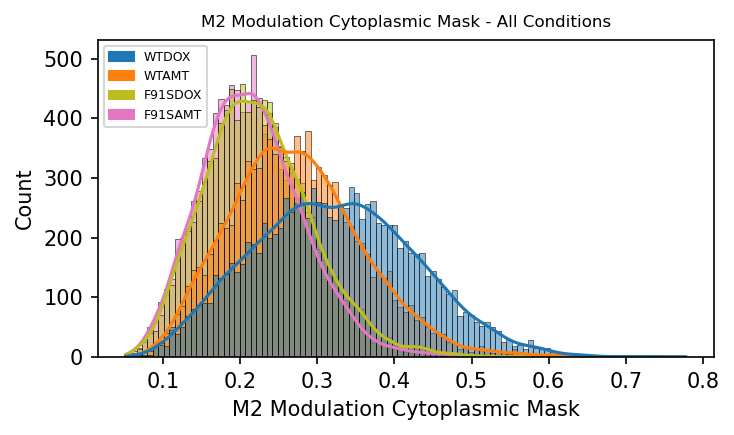

In [130]:
# Formatting data:
plot_dataset = [
    pd.Series(internal_m2[label_array == 0].flatten(), name="M2 Modulation Cytoplasmic Mask"),
    pd.Series(internal_m2[label_array == 1].flatten(), name="M2 Modulation Cytoplasmic Mask"),
    pd.Series(internal_m2[label_array == 2].flatten(), name="M2 Modulation Cytoplasmic Mask"),
    pd.Series(internal_m2[label_array == 3].flatten(), name="M2 Modulation Cytoplasmic Mask")
]

# Formatting data:
plot_dataset = pd.concat(plot_dataset, keys=["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"], names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink']
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    data=plot_dataset, ax=ax, palette=col_labels, stat="count",
    hue="Condition", x="M2 Modulation Cytoplasmic Mask", kde=True)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"], loc=2, prop={'size': 6});

# Titling figure:
plt.title(label="M2 Modulation Cytoplasmic Mask - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(
    fname="F91S Amantadine Analysis/Output Figures/M2 Internal Localisation - All Conditions.png", format="png"
)

In [131]:
feature_index = [idx for idx, feature in enumerate(lda_feature_list) if feature == "Bright Detail Intensity R3_M02_Ch02"]
bdi_gfplc3 = data_array[:, feature_index]

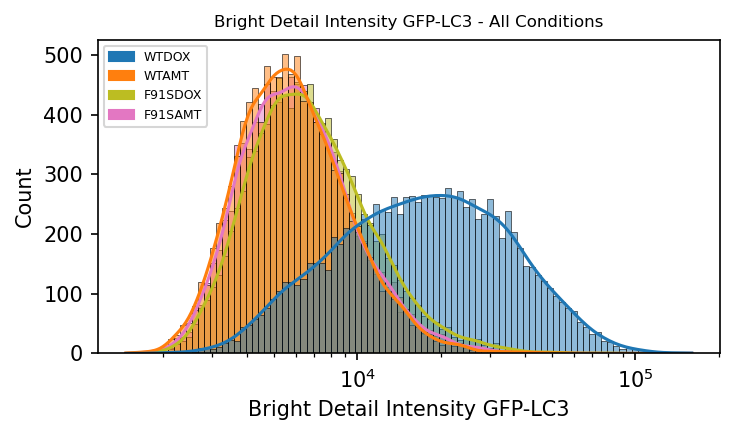

In [132]:
# Formatting data:
plot_dataset = [
    pd.Series(bdi_gfplc3[label_array == 0].flatten(), name="Bright Detail Intensity GFP-LC3"),
    pd.Series(bdi_gfplc3[label_array == 1].flatten(), name="Bright Detail Intensity GFP-LC3"),
    pd.Series(bdi_gfplc3[label_array == 2].flatten(), name="Bright Detail Intensity GFP-LC3"),
    pd.Series(bdi_gfplc3[label_array == 3].flatten(), name="Bright Detail Intensity GFP-LC3")
]

# Formatting data:
plot_dataset = pd.concat(plot_dataset, keys=["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"], names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink']
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    data=plot_dataset, ax=ax, palette=col_labels, stat="count",
    hue="Condition", x="Bright Detail Intensity GFP-LC3", kde=True, log_scale=True)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"], loc=2, prop={'size': 6});

# Titling figure:
plt.title(label="Bright Detail Intensity GFP-LC3 - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(
    fname="F91S Amantadine Analysis/Output Figures/Bright Detail Intensity GFP-LC3 - All Conditions.png", format="png"
)

## 3 Performing single-channel analyses

In [99]:
# Performing LDA and transforming along most discriminable direction on solely M2-derived features:
m2_lda_clf = LinearDiscriminantAnalysis(n_components=2)
m2_lda_embeddings = m2_lda_clf.fit_transform(m2_array, label_array)

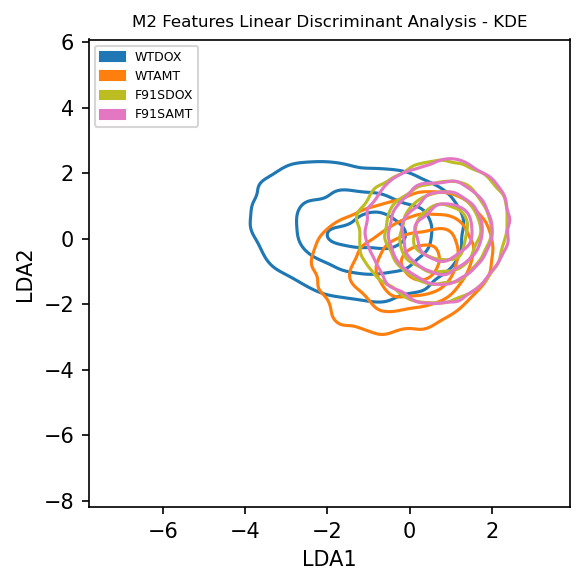

In [107]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(m2_lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(m2_lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(m2_lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(m2_lda_embeddings[label_array == 3, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="M2 Features Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="F91S Amantadine Analysis/Output Figures/M2 Features Linear Discriminant Analysis - KDE.png", format="png")

In [111]:
# Performing LDA and transforming along most discriminable direction on solely M2-derived features:
gfplc3_lda_clf = LinearDiscriminantAnalysis(n_components=2)
gfplc3_lda_embeddings = gfplc3_lda_clf.fit_transform(gfplc3_array, label_array)

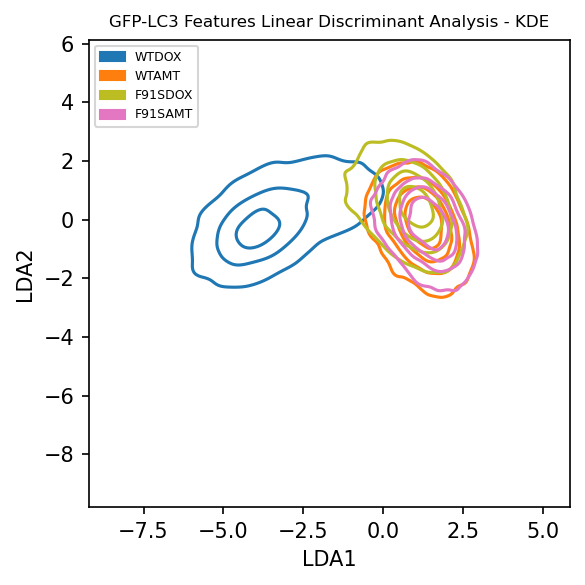

In [112]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(gfplc3_lda_embeddings[label_array == 3, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WTDOX", "WTAMT", "F91SDOX", "F91SAMT"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:orange', 'tab:olive', 'tab:pink']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.1,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(4)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="GFP-LC3 Features Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="F91S Amantadine Analysis/Output Figures/GFP-LC3 Features Linear Discriminant Analysis - KDE.png", format="png")

In [118]:
# Calculating distance between F91SDOX and F91SAMT:
cond_dict = get_embedding_arrays(m2_lda_embeddings)
calculate_diff_distance(cond_dict, 2, 3)

[0.4141685962513506, 0.16128976707032358, 0.26220671246842386]
0.2792216919300327
[0.14406411628038818, 0.7441737972646055, 0.6054950277806412]
0.49791098044187826
0.10044418726201218


In [119]:
# Calculating distance between WTAMT and F91SAMT:
cond_dict = get_embedding_arrays(m2_lda_embeddings)
calculate_diff_distance(cond_dict, 1, 3)

[0.1680661688846284, 0.07485522037610692, 0.17342148884484726]
0.13878095936852752
[0.14406411628038818, 0.7441737972646055, 0.6054950277806412]
0.49791098044187826
1.7376647713866138


In [120]:
# Calculating distance between F91SDOX and F91SAMT:
cond_dict = get_embedding_arrays(gfplc3_lda_embeddings)
calculate_diff_distance(cond_dict, 2, 3)

[0.30057628285801974, 0.0544480833868666, 0.29107096695484236]
0.21536511106657621
[0.16038028662335702, 0.18328132296019314, 0.22589632979751514]
0.18985264646035513
1.2586658028063127


In [121]:
# Calculating distance between WTAMT and F91SAMT:
cond_dict = get_embedding_arrays(gfplc3_lda_embeddings)
calculate_diff_distance(cond_dict, 1, 3)

[0.06778504270830041, 0.1529476268382527, 0.15015565485483393]
0.12362944146712901
[0.16038028662335702, 0.18328132296019314, 0.22589632979751514]
0.18985264646035513
0.24389757440384655
